In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muhammadalbrham/rgb-arabic-alphabets-sign-language-dataset")

print("Path to dataset files:", path)

100%|██████████| 4.72G/4.72G [00:45<00:00, 111MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/muhammadalbrham/rgb-arabic-alphabets-sign-language-dataset/versions/4


In [10]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [11]:
dataset_dir = "/root/.cache/kagglehub/datasets/muhammadalbrham/rgb-arabic-alphabets-sign-language-dataset/versions/4"  # تأكد من وضع مسار المجلد الرئيسي للبيانات هنا


In [12]:
import os
import shutil
from sklearn.model_selection import train_test_split

# مسار المجلد الذي يحتوي على كل الصور
dataset_dir = "/root/.cache/kagglehub/datasets/muhammadalbrham/rgb-arabic-alphabets-sign-language-dataset/versions/4/RGB ArSL dataset"  # تأكد من تحديث المسار بشكل صحيح

# الحصول على جميع الصور
images = [os.path.join(dataset_dir, class_name, img) for class_name in os.listdir(dataset_dir)
          if os.path.isdir(os.path.join(dataset_dir, class_name))  # التأكد من أن العناصر هي مجلدات
          for img in os.listdir(os.path.join(dataset_dir, class_name))
          if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

# استخراج أسماء الفئات من أسماء المجلدات
class_names = [img.split(os.sep)[-2] for img in images]  # الفئة هي اسم المجلد الذي يحتوي الصورة

# تقسيم البيانات إلى تدريب واختبار (80% تدريب، 20% اختبار)
train_imgs, valid_imgs, train_classes, valid_classes = train_test_split(images, class_names, test_size=0.2, random_state=42)

# إعداد مسارات الإخراج
output_dirs = {
    "train": "datasets/train",
    "valid": "datasets/valid",
}




In [13]:
# إنشاء المجلدات
for split in output_dirs:
    os.makedirs(output_dirs[split], exist_ok=True)

# ترميز الفئات إلى أرقام
unique_classes = sorted(set(class_names))
class_to_id = {class_name: idx for idx, class_name in enumerate(unique_classes)}

# نقل الصور إلى المجلدات المناسبة مع الحفاظ على الفئات
for split, data in zip(["train", "valid"], [(train_imgs, train_classes), (valid_imgs, valid_classes)]):
    for img_path, class_name in zip(data[0], data[1]):
        # تحديد المجلد الخاص بالفئة
        class_folder = os.path.join(output_dirs[split], class_name)
        os.makedirs(class_folder, exist_ok=True)  # إنشاء مجلد الفئة إذا لم يكن موجوداً
        # نسخ الصورة إلى المجلد المناسب
        shutil.copy(img_path, class_folder)

print("تم تقسيم البيانات وإعداد الملفات بنجاح!")


تم تقسيم البيانات وإعداد الملفات بنجاح!


In [14]:
from PIL import ImageFile
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

# السماح بتحميل الصور الناقصة
ImageFile.LOAD_TRUNCATED_IMAGES = True

# دالة لمعالجة الصور
def preprocess_images(image_paths, labels, img_size=(128, 128)):
    images = []
    valid_labels = []
    for img_path, label in zip(image_paths, labels):
        try:
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img) / 255.0  # تطبيع القيم إلى [0, 1]
            images.append(img_array)
            valid_labels.append(label)  # فقط الصور الصالحة
        except (OSError, IOError):
            print(f"Skipping corrupted image: {img_path}")
    return np.array(images), np.array(valid_labels)


In [15]:
import os

# تعريف مسار مجلد التدريب
train_dir = "/content/datasets/train"  # استبدلي المسار بمسار المجلد الفعلي

image_paths = []
class_names = []

for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    if os.path.isdir(class_dir):  # التأكد من أن العنصر مجلد
        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(class_dir, img_name))
                class_names.append(class_name)


In [16]:
# **7. إعداد بيانات التدريب والتحقق**
# تحويل أسماء الفئات إلى أرقام
unique_classes = sorted(set(class_names))
class_to_id = {class_name: idx for idx, class_name in enumerate(unique_classes)}


In [17]:
# تحويل الصور إلى مصفوفات NumPy
train_labels = [class_to_id[class_name] for class_name in train_classes]
valid_labels = [class_to_id[class_name] for class_name in valid_classes]

x_train, y_train = preprocess_images(train_imgs, train_labels)
x_valid, y_valid = preprocess_images(valid_imgs, valid_labels)

In [18]:
# **8. إعداد نموذج VGG16**
vgg_base = VGG16(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

# تجميد الطبقات الأساسية
for layer in vgg_base.layers:
    layer.trainable = False

# إضافة طبقات مخصصة
x = Flatten()(vgg_base.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(len(unique_classes), activation="softmax")(x)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
# بناء النموذج
model = Model(inputs=vgg_base.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# **9. إعداد نقاط الحفظ**
checkpoint = ModelCheckpoint("vgg16_sign_language_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1)


# **10. تدريب النموذج**
history = model.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    epochs=20,
    batch_size=32,
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.0807 - loss: 3.4123
Epoch 1: val_accuracy improved from -inf to 0.34415, saving model to vgg16_sign_language_model.keras
197/197 ━━━━━━━━━━━━━━━━━━━━ 27s 93ms/step - accuracy: 0.0809 - loss: 3.4112 - val_accuracy: 0.3441 - val_loss: 2.6924
Epoch 2/20
196/197 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2708 - loss: 2.6460
Epoch 2: val_accuracy improved from 0.34415 to 0.45483, saving model to vgg16_sign_language_model.keras
197/197 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - accuracy: 0.2711 - loss: 2.6449 - val_accuracy: 0.4548 - val_loss: 2.1792
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3913 - loss: 2.1680
Epoch 3: val_accuracy improved from 0.45483 to 0.51272, saving model to vgg16_sign_language_model.keras
197/197 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.3914 - loss: 2.1677 - val_accuracy: 0.5127 - val_loss: 1.8837
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4718 -

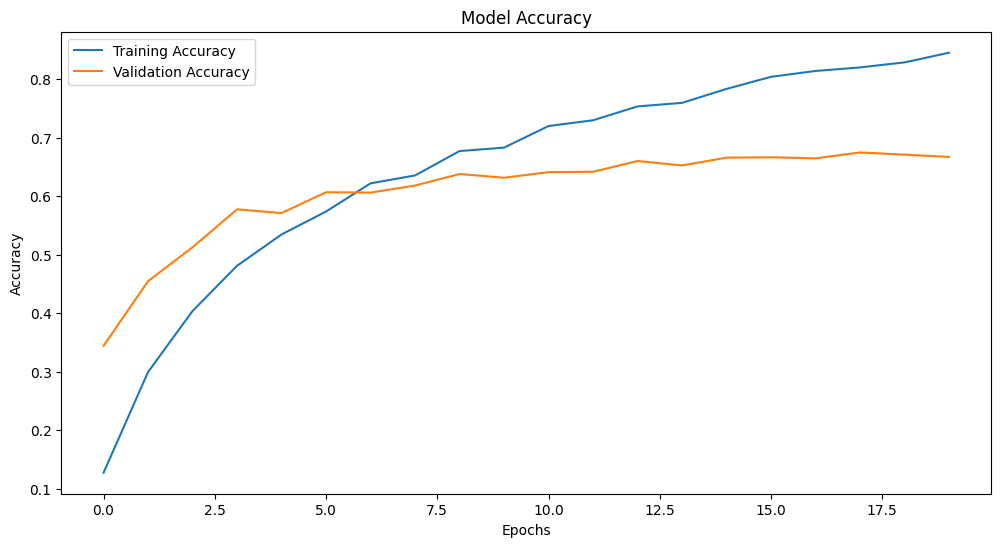

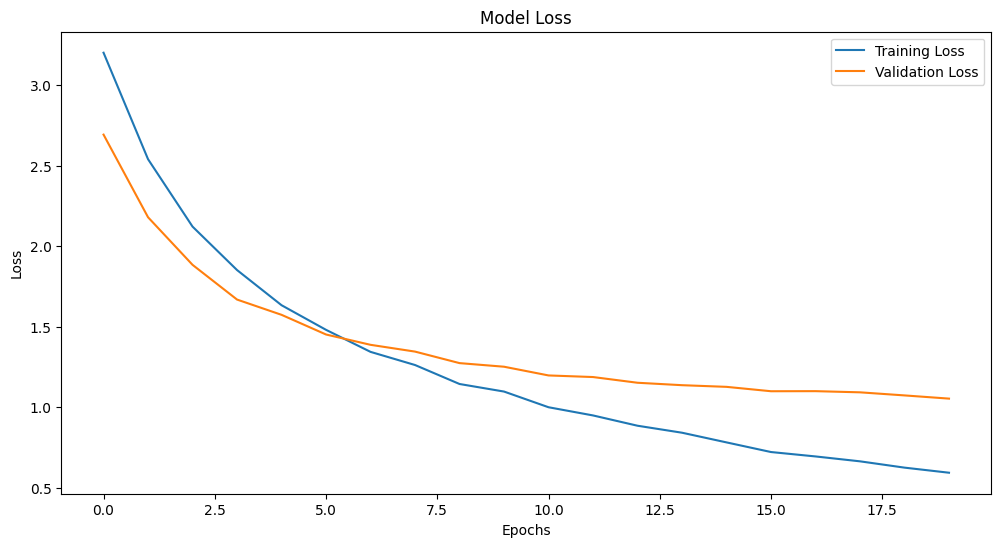

In [20]:
# **11. رسم النتائج**
plt.figure(figsize=(12, 6))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [21]:
# حفظ النموذج
model.save("vgg16_sign_language_model.keras")


In [23]:
from google.colab import files

# تنزيل الملف إلى جهازك
files.download("vgg16_sign_language_model.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
import tensorflow as tf
import tensorflow as tf  # تأكد من استيراد TensorFlow

# تحويل النموذج إلى TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # قم بإنشاء المحول
tflite_model = converter.convert()  # قم بتحويل النموذج

# حفظ النموذج المحول إلى ملف
with open("sign_language_model.tflite", "wb") as f:
    f.write(tflite_model)



Saved artifact at '/tmp/tmpcl1n88ps'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 31), dtype=tf.float32, name=None)
Captures:
  139114772641776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114771684112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114776496256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114771680240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114771682176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114772553696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114774109472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114772556864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114772551232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139114771523968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1391147715267

In [27]:
from google.colab import files

files.download("sign_language_model.tflite")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>